In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Load data

In [3]:
data_file = '../data/huang2011_subsampled.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

250
600


# Load initial fit

In [6]:
fits_dir = '../fits/fits_20201112/' 
filename = fits_dir + 'huang2011_sub_fit_alpha6.0.npz'

In [7]:
vb_opt_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(filename)

vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

# Prior parameters 

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

In [9]:
prior_params_dict

{'dp_prior_alpha': DeviceArray([6.], dtype=float64),
 'allele_prior_alpha': DeviceArray([1.], dtype=float64),
 'allele_prior_beta': DeviceArray([1.], dtype=float64)}

# Check out the fit

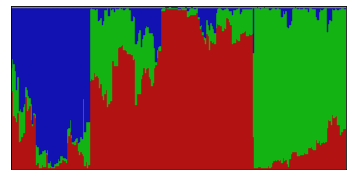

In [10]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(6, 3))
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

# Set up linear response derivatives

In [11]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
# we can do this and set log_phi later because 
# the perturbation is multiplicative 
# (so the hessian at epsilon = 0 does not depend on the perturbation)
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(g_obs, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)


# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.


In [12]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)


Compiling ...
Compile time: 76.9381sec



# Define prior perturbation

In [36]:
delta = 5.0

In [37]:
def log_phi(logit_v):
    return sp.special.expit(logit_v)
    # return - sp.stats.norm.pdf(logit_v, loc = -1.5, scale = 0.5)
    # return((logit_v < -0.55) * (logit_v > -2.56) * delta * -1)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

In [38]:
logit_v_grid = np.linspace(-10, 10, 200)
scale_factor = np.abs(log_phi(logit_v_grid)).max()

def rescaled_log_phi(logit_v): 
    return log_phi(logit_v) / scale_factor * delta

np.abs(rescaled_log_phi(logit_v_grid)).max()

DeviceArray(5., dtype=float64)

In [39]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)


-1.791759469228055 0.9656717840785235 -1.7937718852706863 0.9669178416672084


Text(0.5, 1.0, 'Priors in logit space')

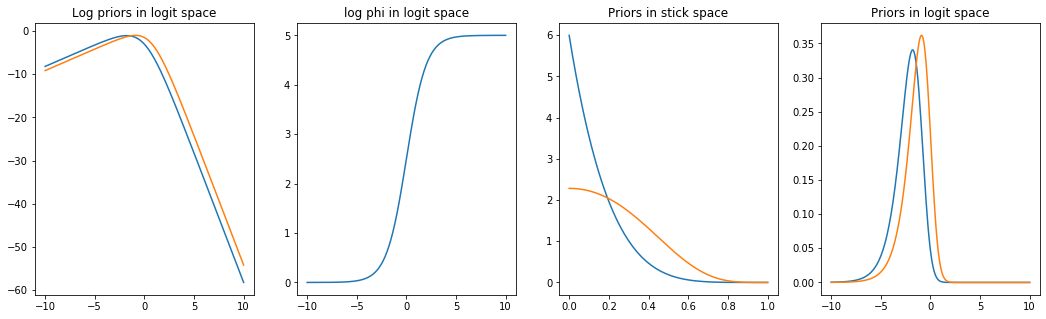

In [40]:
prior_perturbation.set_epsilon(1.0)

v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [41]:
# def get_e_log_perturbation(means, infos, epsilon):
                
#         loc = means
#         scale = 1 / np.sqrt(infos)
        
#         cdf1 = sp.stats.norm.cdf(-0.55, loc, scale)
#         cdf2 = sp.stats.norm.cdf(-2.56, loc, scale)

#         return - (cdf1 - cdf2).sum() * delta * epsilon

In [45]:
def get_e_log_perturbation(means, infos, epsilon): 
    return func_sens_lib.get_e_log_perturbation(rescaled_log_phi,
                                                means, infos,
                                                epsilon, 
                                                gh_loc, gh_weights, 
                                                sum_vector=True)


In [46]:
def _hyper_par_objective_fun(params, epsilon): 
    
    means = params['ind_admix_params']['stick_means']
    infos = params['ind_admix_params']['stick_infos']
    
    return - get_e_log_perturbation(means, infos, epsilon)

# the terms of the KL objective that depend on epsilon 
hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free = True)


# Get derivative for prior perturbation

In [47]:
epsilon_sens._set_cross_hess(hyper_par_objective_fun)
epsilon_sens._set_dinput_dhyper()

In [21]:
epsilon_sens.dinput_dhyper

DeviceArray([-0.00982479, -0.00890072,  0.00947767, ..., -0.13731013,
             -0.13685728, -0.13595183], dtype=float64)

# Load all epsilon fits

In [22]:
fits_dir = '../fits/experimental/'
filenames = 'huang2011_sub_fit_logphi_indx*'

In [23]:
import os 
import re

In [24]:
files = [f for f in os.listdir(fits_dir) if re.match(filenames, f)]

In [25]:
files

['huang2011_sub_fit_logphi_indx2.npz',
 'huang2011_sub_fit_logphi_indx5.npz',
 'huang2011_sub_fit_logphi_indx10.npz',
 'huang2011_sub_fit_logphi_indx4.npz',
 'huang2011_sub_fit_logphi_indx3.npz',
 'huang2011_sub_fit_logphi_indx9.npz',
 'huang2011_sub_fit_logphi_indx0.npz',
 'huang2011_sub_fit_logphi_indx7.npz',
 'huang2011_sub_fit_logphi_indx6.npz',
 'huang2011_sub_fit_logphi_indx1.npz',
 'huang2011_sub_fit_logphi_indx8.npz']

In [26]:
vb_refit_list = []
epsilon_vec = onp.zeros(len(files))

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(fits_dir + files[i])
        
    kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                    gh_loc, gh_weights, 
                                    e_log_phi = lambda means, infos : \
                                                    get_e_log_perturbation(means, 
                                                                           infos, 
                                                                           meta_data['epsilon']))
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    epsilon_vec[i] = meta_data['epsilon']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
epsilon_vec = np.array(epsilon_vec)
vb_refit_list = np.array(vb_refit_list)

loading fit from:  huang2011_sub_fit_logphi_indx2.npz
loading fit from:  huang2011_sub_fit_logphi_indx5.npz
loading fit from:  huang2011_sub_fit_logphi_indx10.npz
loading fit from:  huang2011_sub_fit_logphi_indx4.npz
loading fit from:  huang2011_sub_fit_logphi_indx3.npz
loading fit from:  huang2011_sub_fit_logphi_indx9.npz
loading fit from:  huang2011_sub_fit_logphi_indx0.npz
loading fit from:  huang2011_sub_fit_logphi_indx7.npz
loading fit from:  huang2011_sub_fit_logphi_indx6.npz
loading fit from:  huang2011_sub_fit_logphi_indx1.npz
loading fit from:  huang2011_sub_fit_logphi_indx8.npz


In [27]:
# for convencience, sort the epsilons 
_indx = np.argsort(epsilon_vec)
epsilon_vec = epsilon_vec[_indx]
vb_refit_list = vb_refit_list[_indx]

In [28]:
print('epsilons: ', epsilon_vec)

epsilons:  [0.00826446 0.03305785 0.07438017 0.1322314  0.20661157 0.29752066
 0.40495868 0.52892562 0.66942149 0.82644628 1.        ]


# Check free parameters

In [29]:
lr_list = []

for epsilon in epsilon_vec: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))
    

# Number of clusters

In [30]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(4352)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 1000)

In [31]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

for i in range(len(epsilon_vec)): 
    print(i)
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_refit_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


0
1
2
3
4
5
6
7
8
9
10


In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4)) 

ax_ticksize = 12
ax_titlesize = 20
legend_fontsize = 16

##############
# the perturbation
ax[0].plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid), color = 'grey')
# ax[0].set_xlabel(r'$\tilde \nu_k$', fontsize = ax_titlesize)
ax[0].set_ylabel(r'$\phi(\tilde \nu_k)$', fontsize = ax_titlesize)
ax[0].set_title('Perturbation', fontsize = ax_titlesize)
ax[0].set_ylim(-delta * (1.1), delta * (1.1))

##############
# the priors
ax[1].plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
           color = '#a6cee3', label = r'$p_0$')
ax[1].plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
           color = '#1f78b4', label = r'$p_c$')
# ax[1].set_xlabel(r'$\tilde \nu_k$', fontsize = ax_titlesize)
ax[1].set_ylabel(r'$p(\tilde \nu_k)$', fontsize = ax_titlesize)
ax[1].set_title('Priors', fontsize = ax_titlesize)
ax[1].legend(fontsize = legend_fontsize)

##############
# extrapolation results
ax[2].plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

ax[2].plot(epsilon_vec, lr_e_num_clusters_vec, 
           'o-', color = '#1b9e77', 
           label = 'linear approx.')

ax[2].legend(fontsize = legend_fontsize)
# ax[2].set_xlabel('epsilon', fontsize = ax_titlesize)
ax[2].set_ylabel('E[num. clusters]', fontsize = ax_titlesize)
ax[2].set_ylim(4.7, 5.21)

for i in range(2):     
    ax[i].tick_params(axis='both', which='major', labelsize=ax_ticksize)

fig.tight_layout()

# Figure for paper

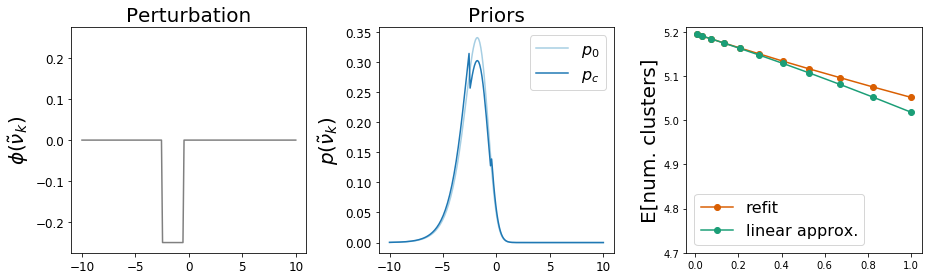

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4)) 

ax_ticksize = 12
ax_titlesize = 20
legend_fontsize = 16

##############
# the perturbation
ax[0].plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid), color = 'grey')
# ax[0].set_xlabel(r'$\tilde \nu_k$', fontsize = ax_titlesize)
ax[0].set_ylabel(r'$\phi(\tilde \nu_k)$', fontsize = ax_titlesize)
ax[0].set_title('Perturbation', fontsize = ax_titlesize)
ax[0].set_ylim(-delta * (1.1), delta * (1.1))

##############
# the priors
ax[1].plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
           color = '#a6cee3', label = r'$p_0$')
ax[1].plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
           color = '#1f78b4', label = r'$p_c$')
# ax[1].set_xlabel(r'$\tilde \nu_k$', fontsize = ax_titlesize)
ax[1].set_ylabel(r'$p(\tilde \nu_k)$', fontsize = ax_titlesize)
ax[1].set_title('Priors', fontsize = ax_titlesize)
ax[1].legend(fontsize = legend_fontsize)

##############
# extrapolation results
ax[2].plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

ax[2].plot(epsilon_vec, lr_e_num_clusters_vec, 
           'o-', color = '#1b9e77', 
           label = 'linear approx.')

ax[2].legend(fontsize = legend_fontsize)
# ax[2].set_xlabel('epsilon', fontsize = ax_titlesize)
ax[2].set_ylabel('E[num. clusters]', fontsize = ax_titlesize)
ax[2].set_ylim(4.7, 5.21)

for i in range(2):     
    ax[i].tick_params(axis='both', which='major', labelsize=ax_ticksize)

fig.tight_layout()